In [67]:
import os 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [68]:
def read_ml_small():
    data_dir = './ml-100k/ratings.csv'
    data = pd.read_csv(data_dir)
    num_users = data.userId.unique().shape[0]
    num_items = data.movieId.unique().shape[0]
    
    return data, num_users, num_items

In [69]:
data, num_users, num_items = read_ml_small()
sparsity = 1 - len(data) / (num_users * num_items) # 데이터에서 rating이 빈 것의 비율(행렬 만들었을 때)

print(f'유저수 : {num_users}') 
print(f'영화수 : {num_items}')
print(f'matrix sparsity : {sparsity}')
print(data.sample(5))

유저수 : 610
영화수 : 9724
matrix sparsity : 0.9830003169443864
       userId  movieId  rating   timestamp
65844     424    27020     3.5  1457901562
11047      68     5266     2.0  1158533058
60243     387    53129     3.5  1200321462
47277     307     4662     3.5  1224508399
57226     380     2761     4.0  1493420312


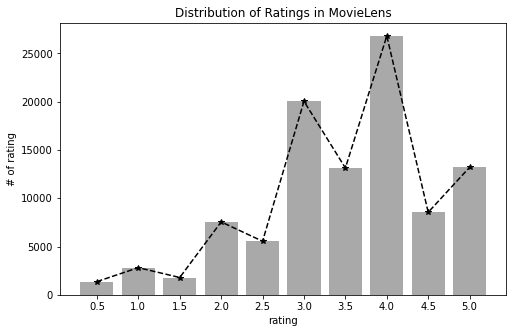

In [70]:
# count rating barchart
rating_cnt = data.rating.value_counts().sort_index()

fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.plot(rating_cnt, 
       color = 'black',
       marker = '*',
       linestyle = '--')
ax.bar(rating_cnt.index, rating_cnt, 
       color = 'darkgray',
       width = 0.4)

ax.set_title('Distribution of Ratings in MovieLens')
ax.set_xlabel('rating')
ax.set_ylabel('# of rating')
ax.set_xticks(rating_cnt.index)
plt.show()

데이터 세트를 훈련 및 테스트 세트로 분할합니다.   

`random` 및 `seq-aware`를 포함하는 2개의 분할 모드를 제공  

`랜덤 모드` : 시간요인을 고려하지 않고 무작위로 100k 상호작용을 분할하고 데이터의 90% 를 트레이닝 샘플로 사용
하고 나머지 10% 는 기본적으로 테스트 샘플로 사용합니다. 

`seq-aware` 
사용자가 테스트를 위해 가장 최근에 평가한 항목과 훈련 세트로서의 사용자의 히스토리 상호작용을 제외한다.   
사용자 히스토리 상호작용은 시간소인을 기반으로 가장 오래된 항목부터 최신 항목 순으로 정렬됩니다.   
이 모드는 `sequence-aware recommendation section` 에서 사용됩니다..

In [105]:
def split_data_ml100k(data, test_ratio=0.1):
    user_id_unq = data.userId.unique()
    mask = []
    for i in user_id_unq:
        data_user = data[data['userId'] == i]
        mask.extend([True if x == 1 else False for x in np.random.uniform(0,1,len(data_user)) < 1-test_ratio])
    neg_mask = [not x for x in mask]
    train_data, test_data = data[mask], data[neg_mask]

    return train_data, test_data

train_data, test_data = split_data_ml100k(data, test_ratio=0.1)
    
print(len(train_data), len(test_data))

90879 9957


In [106]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(data['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(data['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

#user_decoder

In [115]:
from torch.utils.data import Dataset

class MovielensDataset(Dataset):
    """MovieLens dataset"""
    
    def __init__(self,data, user_encoder, item_decoder):
        self.data = data
        self.user_encoder, self.item_encoder = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.data.userId.values]) 
        self.item = torch.tensor([self.item_encoder[i] for i in self.data.movieId.values]) # long tensor
        self.rating = torch.tensor(self.data.rating.values) # float
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.user[idx], self.item[idx], self.rating[idx]
        

In [124]:
from torch import nn
from torch.nn import Module

class MF(Module):
    """MF"""
    
    def __init__(self, num_factors, num_users, num_items):
        super(MF,self).__init__()
        # set latent matrix shape
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        
        # set bias shape
        self.user_bias = nn.Embedding(num_users,  1)
        self.item_bias = nn.Embedding(num_items,  1)
        
    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)

        output = torch.sum((P_u*Q_i),axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i)
        
        return outputs.view(-1)

In [125]:
def train(model, trian_loader):
    model.train()
    train_loss = 0
    
    for user,item, rating in trian_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        output = model(user, item)
        
        loss = criterion(output, rating)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss/len(train_loader)
    
    return train_loss

In [126]:
def evaluation(model, test_loader):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for user,item, rating in trian_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            loss = criterion(output, rating)

            test_loss += loss.item()
    test_loss = test_loss / len(test_loader)
    
    return test_loss

In [127]:
num_factors = 30
batch_size = 128
epochs = 30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.01
device

device(type='cuda')

In [131]:
model = MF(num_factors, num_users, num_items).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

RuntimeError: CUDA error: device-side assert triggered

In [129]:
from torch.utils.data import DataLoader

train_data, val_data = split_data_ml100k(data, test_ratio = 0.1)

train_dataset = MovielensDataset(train_data,user_encoder,item_encoder)
val_dataset = MovielensDataset(val_data,user_encoder,item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

In [130]:
best_metric = 1

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_metric:
        best_metric = val_loss
        

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"